# Forecasting in TensorFlow

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/AI_4_Climate_Bootcamp/blob/main/Week 05 - Advanced ML Applications/1. Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In this notebook, we'll explore the basics of time series forecasting using TensorFlow. Time series forecasting is the process of predicting future values based on past observations. It is widely used in areas such as finance, economics, and climate change.

We'll start by discussing the different types of time series and the challenges associated with time series forecasting. Then, we'll cover the basics of TensorFlow and how to use it for time series forecasting. Finally, we'll build a simple time series forecasting model using TensorFlow and evaluate its performance.

By the end of this notebook, you will have a good understanding of how to use TensorFlow for time series forecasting and how to build a simple forecasting model.

* [Time Series Forecasting with TensorFlow])(https://www.tensorflow.org/tutorials/structured_data/time_series)


## Table of Contents <a name="toc"></a>
- [Dataset Download & Preparation](#dataset)
  - [Exploratory Data Analysis](#eda)
  - [Data Preprocessing](#preprocessing)
    - [Standardization](#standardization)
    - [Train-Test Split](#train_test_split)
    - [Windowing](#windowing)
- [Model Building](#model_building)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import model_selection, preprocessing

## Dataset Download & Preparation <a name="dataset"></a>
[Back to Top](#toc)

We will be using `jena_climate_2009_2016` dataset is a time series dataset that contains 14 climate-related variables, such as temperature, pressure, and humidity, recorded every 10 minutes from 2009 to 2016 in Jena, Germany. The dataset is commonly used for time series forecasting and provides a good starting point for learning about time series forecasting.

The dataset contains 420,551 records, where each record contains 14 variables and a timestamp. The variables are:

- `Date Time`: Timestamp of the record
- `p (mbar)`: Pressure in millibars
- `T (degC)`: Temperature in degrees Celsius
- `Tpot (K)`: Temperature potential in Kelvin
- `Tdew (degC)`: Dew point temperature in degrees Celsius
- `rh (%)`: Relative humidity in percent
- `VPmax (mbar)`: Maximum vapor pressure in millibars
- `VPact (mbar)`: Actual vapor pressure in millibars
- `VPdef (mbar)`: Vapor pressure deficit in millibars
- `sh (g/kg)`: Specific humidity in grams per kilogram
- `H2OC (mmol/mol)`: Water vapor concentration in millimoles per mole
- `rho (g/m**3)`: Air density in grams per cubic meter
- `wv (m/s)`: Vertical wind velocity in meters per second
- `max. wv (m/s)`: Maximum vertical wind velocity in meters per second
- `wd (deg)`: Wind direction in degrees




In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"

# download and extract dataset file
tf.keras.utils.get_file(
    origin=uri,
    fname="jena_climate_2009_2016.csv.zip",
    extract=True,
    cache_dir=".",
    cache_subdir="",
)

13568290/13568290 [==============================] - 1s 0us/step


'./jena_climate_2009_2016.csv.zip'

In [2]:
# read dataset from CSV using Pandas
df = pd.read_csv("jena_climate_2009_2016.csv")
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [3]:
# let's create a human readable table of the features and their titles

key_title_dictionary = {
    "p (mbar)": "Pressure",
    "T (degC)": "Temperature",
    "Tpot (K)": "Temperature in Kelvin",
    "Tdew (degC)": "Temperature (dew point)",
    "rh (%)": "Relative Humidity",
    "VPmax (mbar)": "Saturation vapor pressure",
    "VPact (mbar)": "Vapor pressure",
    "VPdef (mbar)": "Vapor pressure deficit",
    "sh (g/kg)": "Specific humidity",
    "H2OC (mmol/mol)": "Water vapor concentration",
    "rho (g/m**3)": "Airtight",
    "wv (m/s)": "Wind speed",
    "max. wv (m/s)": "Maximum wind speed",
    "wd (deg)": "Wind direction in degrees",
}

pd.DataFrame.from_dict(key_title_dictionary, orient="index", columns=["Title"])

,Title
p (mbar),Pressure
T (degC),Temperature
Tpot (K),Temperature in Kelvin
Tdew (degC),Temperature (dew point)
rh (%),Relative Humidity
VPmax (mbar),Saturation vapor pressure
VPact (mbar),Vapor pressure
VPdef (mbar),Vapor pressure deficit
sh (g/kg),Specific humidity
H2OC (mmol/mol),Water vapor concentration


### Exploratory Data Analysis <a name="eda"></a>
[Back to Top](#toc)

We will now load the dataset and perform some exploratory data analysis to get a better understanding of the data.


In [4]:
# check for missing values
df.isna().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [5]:
# desribe the dataset using Pandas

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


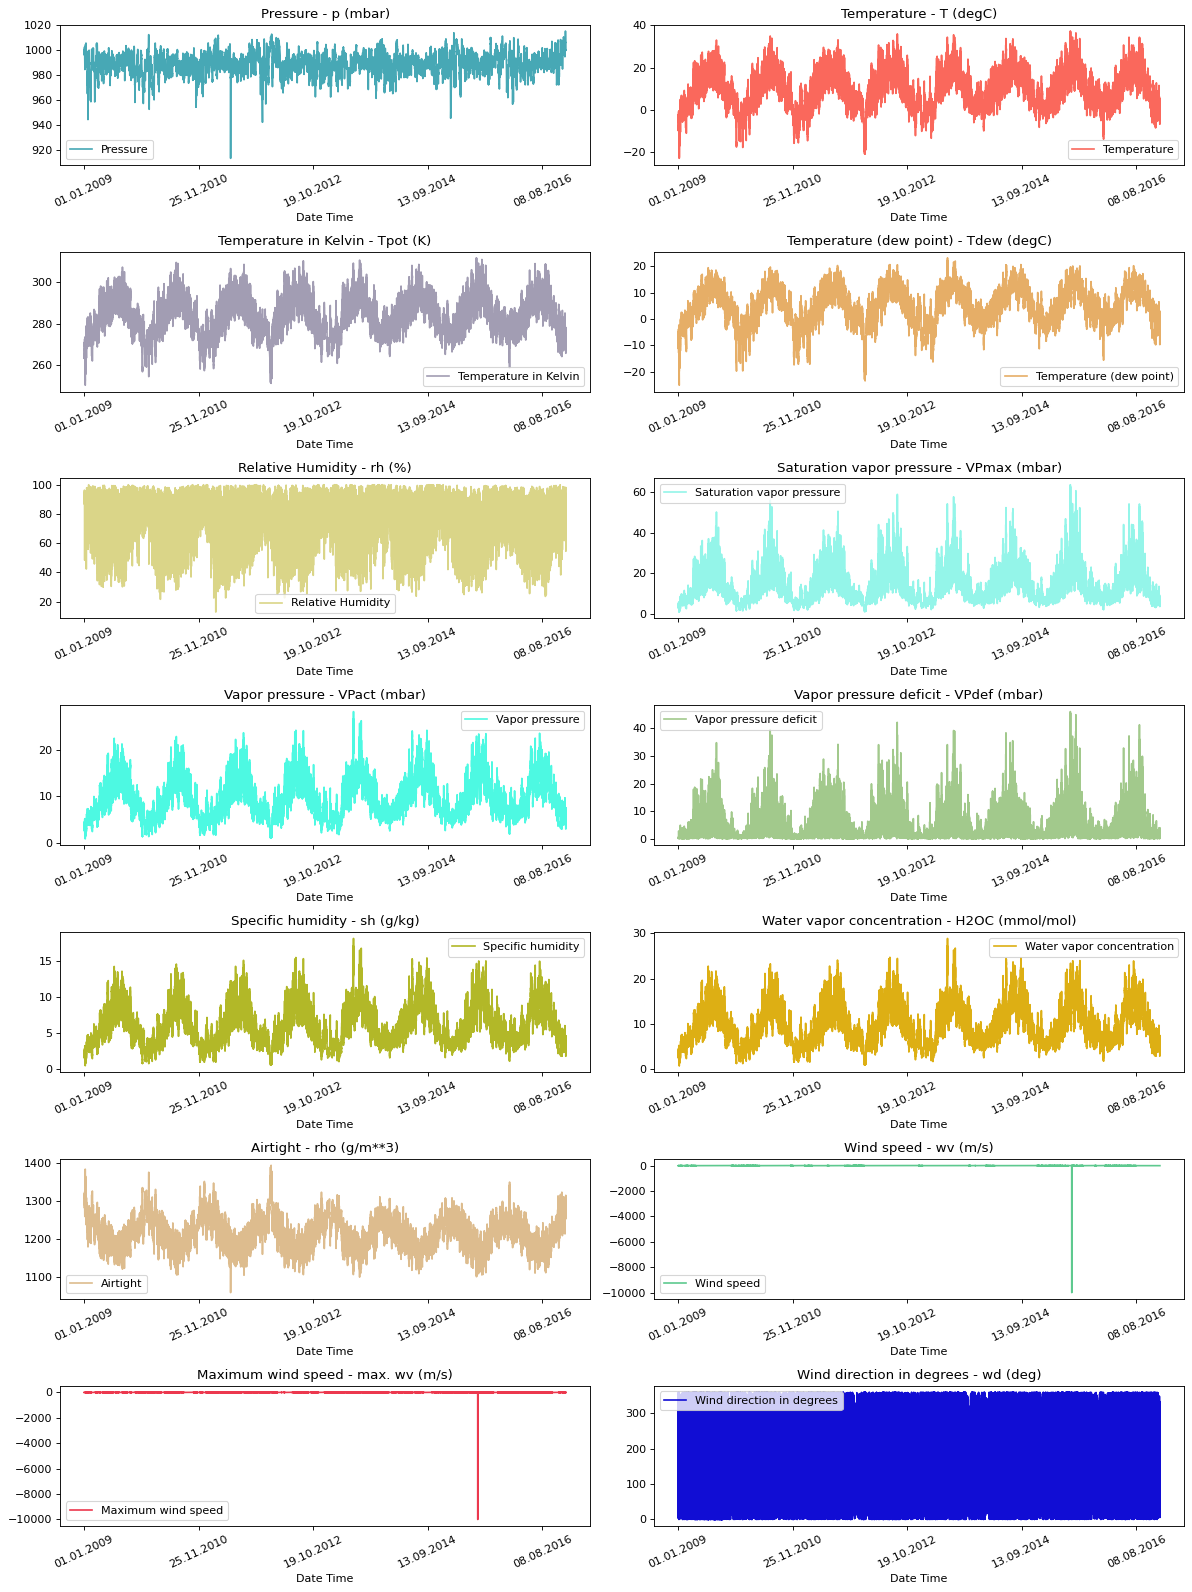

In [6]:
# visualize the data

time_data = df["Date Time"].str.slice(
    start=0, stop=10
)  # slice the date from the datetime string

fig, axes = plt.subplots(
    nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
)  # create a 7x2 grid of subplots

for i, key in enumerate(key_title_dictionary.keys()):  # iterate over the features
    c = np.random.rand(
        3,
    )  # generate a random color for each feature
    t_data = df[key]  # get the feature data
    t_data.index = time_data  # set the index to the formatted date
    t_data.head()  # show the first 5 rows of the data
    ax = t_data.plot(
        ax=axes[i // 2, i % 2],
        color=c,
        title="{} - {}".format(key_title_dictionary[key], key),
        rot=25,
    )  # plot the data on the subplot
    ax.legend([key_title_dictionary[key]])  # add a legend to the subplot

plt.tight_layout()  # adjust the subplots to fit the figure area

/var/folders/c2/n3k7ds5543jfp3w00w6t33200000gn/T/ipykernel_44560/120220884.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr())


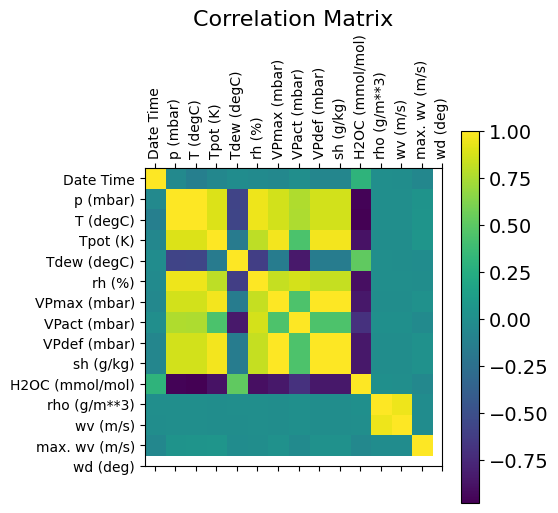

In [7]:
# This heat map shows the correlation between different features.

plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

### Preprocessing <a name="preprocessing"></a>
[Back to Top](#toc)

We will now preprocess the dataset to make it suitable for time series forecasting. We will perform the following preprocessing steps:
- Define the hyperparameters
- Drop redundant columns
- Normalize the dataset
- Create training and validation splits
- Window the dataset

In [8]:
# hyperparameters

train_fraction = 0.7  # fraction of the dataset to use for training
train_split = int(train_fraction * int(df.shape[0]))  # split index

rph = 6  # records per hour
past = 720  # past 5 days (rph * 24 * 5)
future = 72  # next 12 hours (rph * 12)
batch_size = 256  # batch size

We will be dropping some redundant columns from the dataset. The `Date Time` column is not needed for training the model, so we will drop it. The `Tpot (K)`, `Tdew (degC)`, `rh (%)`, `VPact (mbar)`, `H2OC (mmol/mol)`, `max. wv (m/s)` columns are redundant and can be dropped. The `rho (g/m**3)` column is highly correlated with the `p (mbar)` column, so we will drop it as well.

In [9]:
# put columns names that we intend to use in a list for easy reference
selected_columns = [
    "p (mbar)",
    "T (degC)",
    "VPmax (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "rho (g/m**3)",
    "wv (m/s)",
]

# create a new dataframe with only the selected columns
dataset_df = df[selected_columns]
dataset_df

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
0,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
1,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
2,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
3,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
4,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32
...,...,...,...,...,...,...,...
420546,1000.07,-4.05,4.52,1.22,2.06,1292.98,0.67
420547,999.93,-3.35,4.77,1.44,2.07,1289.44,1.14
420548,999.82,-3.16,4.84,1.55,2.05,1288.39,1.08
420549,999.81,-4.23,4.46,1.26,1.99,1293.56,1.49


### Standardization <a name="standardization"></a>
[Back to Top](#toc)

We will now standardize the dataset. Standardization is a common preprocessing step that is used to transform the values of each column to have a mean of 0 and a standard deviation of 1. This helps to make the training process more stable and faster.

In [10]:
# standardize the data using StandardScaler from sklearn.preprocessing

scaler = preprocessing.StandardScaler()  # create a scaler object
scaler.fit(dataset_df)  # fit the scaler to the dataset

dataset_df = scaler.transform(dataset_df)  # transform the dataset

dataset_df = pd.DataFrame(
    dataset_df, columns=selected_columns
)  # convert the dataset to a dataframe
dataset_df.describe().transpose()  # show the dataset statistics

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,5.622396e-14,1.000001,-9.046245,-0.599724,0.043934,0.658879,3.127034
T (degC),420551.0,1.124566e-16,1.000001,-3.853589,-0.723007,-0.003579,0.714662,3.303892
VPmax (mbar),420551.0,2.595152e-16,1.000001,-1.631507,-0.748965,-0.226935,0.519931,6.485809
VPdef (mbar),420551.0,6.487879e-17,1.000001,-0.825513,-0.647848,-0.378287,0.256816,8.570332
sh (g/kg),420551.0,-5.406566e-16,1.000001,-2.079114,-0.791529,-0.162796,0.669240,4.558348
rho (g/m**3),420551.0,5.297353e-15,1.000001,-3.917752,-0.714763,-0.056854,0.668096,4.439688
wv (m/s),420551.0,9.968356e-19,1.000001,-152.806971,-0.010883,0.000883,0.017690,0.409307


### Train-Test Split <a name="train-test-split"></a>
[Back to Top](#toc)

In [11]:
# split data into train and test sets using the train_split index

train_data = dataset_df.loc[0 : train_split - 1]
test_data = dataset_df.loc[train_split:]

dataset_df.shape, train_data.shape, test_data.shape

((420551, 7), (294385, 7), (126166, 7))

### Windowing the Dataset for Forecasting

Windowing the dataset is a crucial step in building a time series forecasting model, as it helps to convert the series of data into a format that is easier to model and make predictions. The basic idea behind windowing is to divide the time series data into windows of a fixed size and use these windows to train the model. Each window contains a fixed number of time steps (e.g., 720 time steps) and the target to predict is the temperature at the next time step (or several time steps, depending on the forecasting horizon).

The process of windowing the dataset will be done in two steps:
- Shift the dataset to create input and target sequences for training to align the start of each sequence with the target to predict.
- Using `tf.keras.preprocessing.timeseries_dataset_from_array` to create a `tf.data.Dataset` object from the input and target sequences.

In [13]:
# let's create x_train and y_train

x_train = train_data.values  # all training timesteps from 0 to train_split

y_train_start = past + future  # first target index = past + future (720 + 72 = 792)
y_train_end = (
    y_train_start + train_split
)  # last target index = start + train_split (792 + train_split)

# all targets from 792 to train_split + 792
y_train = dataset_df.iloc[y_train_start:y_train_end][
    ["T (degC)"]
].values  # note that we only select the "T (degC)" column as the target since we are trying to predict temperature

x_train.shape, y_train.shape

((294385, 7), (294385, 1))

In [14]:
# now create x_test and y_test

# specify the end of the x_test data by accounting for the past and future timesteps that will be used for the target (y)
x_test_end = (
    len(test_data) - future - past
)  # last x_test index = len(dataset_df) - future - past ( - 72 - 720 = 419759)

x_test = test_data.iloc[:x_test_end].values  # pick up from where y_train left off

# specify the start of the y_test data by accounting for the past and future timesteps that will be used for the target (y)
y_start = train_split + past + future  # first target index = train_split + 720 + 72

y_test = dataset_df.iloc[y_start:][
    ["T (degC)"]
].values  # note that we only select the "T (degC)" column as the target since we are trying to predict temperature

x_test.shape, y_test.shape

((125374, 7), (125374, 1))

Now that the features (`x`) and targets (`y`) are shifted, we can use `tf.keras.preprocessing.timeseries_dataset_from_array` to create a `tf.data.Dataset` object from the input and target sequences. This function takes the following arguments:
- `x`: The input sequence.
- `y`: The target sequence.
- `sequence_length`: The length of the input sequence.
- `sampling_rate`: The sampling rate of the input sequence.
- `batch_size`: The batch size.

We will also be sampling the dataset at a rate of 6, which means that we will be using one data point every 10 minutes. This is done to reduce the size of the dataset and make it easier to train the model.

In [ ]:
sampling_rate = rph  # sample every hour
sequence_length = int(
    past / rph
)  # number of timestamps to use for each training sample

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

In [16]:
# preview train_dataset, including total size and sample input/output
for batch in train_dataset.take(1):
    print("Input shape:", batch[0].shape)
    print("Output shape:", batch[1].shape)

# print total size of dataset
print("Total size of dataset:", len(train_dataset))

Input shape: (256, 120, 7)
Output shape: (256, 1)
Total size of dataset: 1148


2023-02-12 10:53:08.375105: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Model Building <a name="model"></a>
[Back to Top](#toc)

We will now build a simple time series forecasting model using TensorFlow. The model will be an LSTM model with a single dense layer. The model will be trained using the default Adam optimizer and the new `huber` loss function. The `huber` loss function is a robust loss function that is less sensitive to outliers in the data.

In [18]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(
            32, input_shape=(sequence_length, len(selected_columns))
        ),  # input shape is sequence_length (720) x number of features (7)
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint.h5",
    save_best_only=True,
    monitor="val_loss",
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
)

model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Epoch 1/10


2023-02-12 11:00:55.041324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-12 11:00:55.175436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-12 11:00:55.537066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1148/1148 [==============================] - ETA: 0s - loss: 0.1017 - mean_absolute_error: 0.3463

2023-02-12 11:01:35.204587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-12 11:01:35.263262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1148/1148 [==============================] - 50s 42ms/step - loss: 0.1017 - mean_absolute_error: 0.3463 - val_loss: 0.0702 - val_mean_absolute_error: 0.2956
Epoch 2/10
1148/1148 [==============================] - 47s 41ms/step - loss: 0.0665 - mean_absolute_error: 0.2834 - val_loss: 0.0672 - val_mean_absolute_error: 0.2868
Epoch 3/10
1148/1148 [==============================] - 47s 41ms/step - loss: 0.0626 - mean_absolute_error: 0.2754 - val_loss: 0.0696 - val_mean_absolute_error: 0.2918
Epoch 4/10
1148/1148 [==============================] - 47s 41ms/step - loss: 0.0600 - mean_absolute_error: 0.2704 - val_loss: 0.0719 - val_mean_absolute_error: 0.2974
Epoch 5/10
1148/1148 [==============================] - 48s 41ms/step - loss: 0.0587 - mean_absolute_error: 0.2677 - val_loss: 0.0705 - val_mean_absolute_error: 0.2948


10/10 [==============================] - 0s 22ms/step


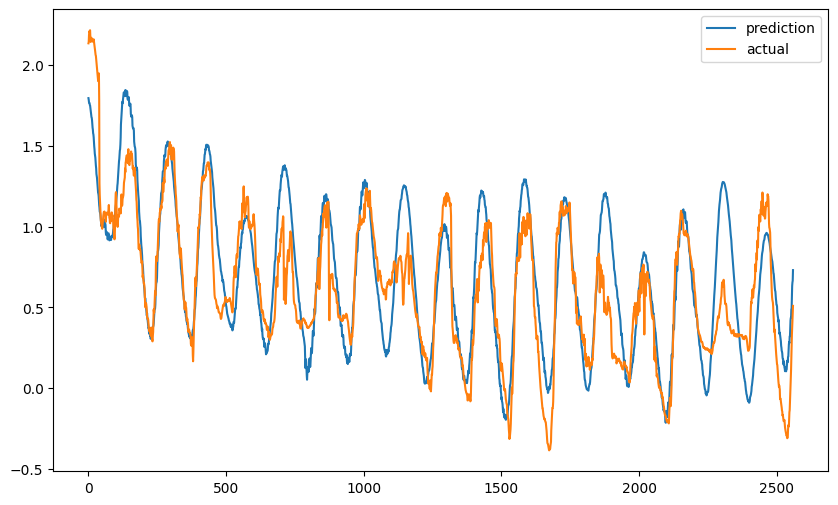

In [26]:
test_dataset_subset = test_dataset.take(
    10
)  # take the first 5 batches of the test dataset

# get the predictions for the test samples
predictions = model.predict(test_dataset_subset)

# get the actual values for the test samples
actual_values = []
for batch in test_dataset_subset:
    actual_values.extend(batch[1])  # batch[1] is the target value (y)

# plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(predictions, label="prediction")
plt.plot(actual_values, label="actual")
plt.legend()
plt.show()